# master_neutrons statistics

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = 26, 10
plt.style.use('fivethirtyeight')

# custom analysis tools
from analysis.scan import scan
from analysis.tools import plot_it
from analysis.tools import get_diff
from analysis.tools import extract_species

# useful python libraries
import pandas as pd

STUDY = 'master_neutrons'

# Get the current directory where the Jupyter Notebook is located

current_directory = get_ipython().run_line_magic('pwd', '')

# Extract the local path to 3CS folder
local_path        = current_directory.split('repo_note3cs')[0]

# Define path to study within data3cs folder
path_to_study     = f'repo_data3cs/data3cs/studies/{STUDY}'

# Final path
path              = f'{local_path}{path_to_study}'

## Functions

In [3]:
def Normal(x, m, s):
    return (1 / s * np.sqrt(2*np.pi)) * np.exp( -0.5 * ((x - m)**2) / (s**2) )


def Gaussian(x, m, s, A):
    return A * np.exp( -0.5 * ((x - m)**2) / (s**2) )


def get_Gaussian_Area(s, A):
    return A*s/0.3989

def moving_average(x_array, y_array, window):

    new_x      = []
    avr_array = []
    for i in range(window, len(y_array) - window):

        new_x.append(x_array[i])
        
        val = 0
        for j in range(1, window):
            right = y_array[i+j]
            left=y_array[i-j]

            if right != np.nan:
                val+= right
            if left != np.nan:
                val+= left
        if y_array[i] != np.nan:
            val+=y_array[i]
        avr_array.append(val/(window*2 +1))
    
    return new_x, avr_array

def get_likelihood(data, sigma_noise, m, s, A):
    
    x_data, y_data = data
    mean_values = Gaussian(x_data, m, s, A)
    log_likelihoods =( -0.5 * np.log(2 * np.pi * sigma_noise**2) - 0.5 * ((y_data - mean_values) / sigma_noise)**2 ) #+ ((s - 40)**2)/10000
    log_likelihood = np.sum(log_likelihoods)
    
    return log_likelihood


def get_2d_likelihoods(data, s_noise, m, s_range, A_range):

    result_matrix = np.zeros((len(s_range), len(A_range)))

    for i, s in enumerate(s_range):
        for j, A in enumerate(A_range):
            result = get_likelihood(data, s_noise, m, s, A)
            result_matrix[i, j] = result

    max_val = result_matrix.max() 
    max_xy = np.where(result_matrix == max_val)

    s_ind = max_xy[0][0]
    A_ind = max_xy[1][0]
    
    s_mle =  np.round(s_range[s_ind], 4)
    A_mle = np.round(A_range[A_ind], 4)

    return result_matrix, s_mle, A_mle, [max_val, max_xy]


def get_LLR(data, s_noise, m, s_range, A_range, s_mle, A_mle):

    H0 = get_likelihood(data, s_noise, m, s_mle, A_mle)

    H1, _, _, _ = get_2d_likelihoods(data, s_noise, m, s_range, A_range)

    LLR = -2 * (np.subtract(H1, H0))

    return LLR


def plot_heatmap(matrix, s_arr, A_arr, textbox = None, title = 'Signal Contour Map'):

    # Create a heatmap
    ax = sns.heatmap(matrix, cmap="rocket_r", vmin=0, vmax=18)
    
    # Set the number of desired ticks on the x and y axes
    num_x_ticks = 25
    num_y_ticks = 9
    
    ss_r = np.round(s_arr, 0)
    As_r = np.round(A_arr,2)
    
    # Calculate the x and y tick positions
    x_tick_positions = np.linspace(0, len(As_r) - 1, num_x_ticks)
    y_tick_positions = np.linspace(0, len(ss_r) - 1, num_y_ticks)
    
    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(x_tick_positions)
    ax.set_yticks(y_tick_positions)
    ax.set_xticklabels(As_r[np.round(x_tick_positions).astype(int)])
    ax.set_yticklabels(ss_r[np.round(y_tick_positions).astype(int)])
    
    ax.set_ylabel(r'$\sigma \; [nm]$', fontsize = 20)
    ax.set_xlabel(r'$A \;$ [Photons sec$^{-1} \, \mu W^{-1}$]', fontsize = 20)
    
    # Define specific contour levels you want to display
    specific_contour_levels          = [1,4,9]
    
    S, A = np.meshgrid(s_arr, A_arr)
    contour = plt.contour(matrix, levels=specific_contour_levels, colors='black')
    
    sigma_dict = {1 : r'$1\sigma$', 4 : r'$2\sigma$' , 9 : r'$3\sigma$' }
    
    # Add labels with the renamed contour levels
    plt.clabel(contour, inline=1, fontsize=15, fmt = sigma_dict)
    
    # Add faint grid
    plt.grid("on", color = 'grey', linestyle = '--', alpha = 0.7)
    plt.grid(visible=True, which='minor', color='gray', linestyle='--', linewidth=0.25, alpha = 0.75) 
    plt.minorticks_on()
    ax.invert_yaxis()

    if textbox != None:
    
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='white', alpha=0.25)
            
        # place a text box in upper left in axes coords
        ax.text(0.75, 0.95, textbox, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)


    # Create the colorbar and label it
    cbar = ax.collections[0].colorbar
    cbar.set_label('Log-Likelihood Ratio', fontsize=15)  # Customize the label here

    
    plt.title(title, fontsize = 25)
    
    #plt.legend(fontsize=14)

    return None

def sim_data(s_noise, m, s, A, size, toplot = False):
    
    x_arr = np.linspace(250,250+450, size)
    y_arr   = Gaussian(x_arr, m, s, A_sim) + s_noise * np.random.randn(size)
    data = [x_arr, y_arr]

    strength = get_Gaussian_Area(s, A)
    
    if toplot == True:
        # plot simulated signal
        plt.scatter(x_arr, y_arr, color='y', label =  'Simulated Data', s = 25, marker = 'x')
        plt.plot(x_arr, Gaussian(x_arr, m, s, A_sim), color = 'red', label = 'Signal')
        plt.xlabel(r'Emission Wavelength $[nm]$', fontsize = 15)
        plt.ylabel(r'[Photons sec$^{-1} \, \mu W^{-1}$]', fontsize = 15)
        plt.title(rf'$\sigma$ = {s},  $A$ = {A_sim}', fontsize = 30);
        plt.grid("on", alpha = 0.25)
        plt.minorticks_on()
        plt.grid(visible=True, which='minor', color='lightgray', linestyle='--', linewidth=0.25) 
        plt.legend()    
    
    return data, s_noise, m, strength


def area_stat(input_data, m, s_arr, A_arr, toplot = False, sig_threshold = 1, sim = False) :

    if sim == True:
        data, s_noise, _, _  = input_data

    else:
        data, s_noise = input_data
    
    # get mle of s,A from sim data
    mtx, s_mle, A_mle, max = get_2d_likelihoods(data, s_noise, m, s_arr, A_arr)

    # calculate log-likelihood ratio matrix of data
    LLR = get_LLR(data, s_noise, m, s_arr, A_arr, s_mle, A_mle)

    # --- LLR is the important object, from it we get all the elements that fall
    # --- under the selected significance thershold which will give us the range
    # --- of areas of the signal

    threshold = sig_threshold  # Change this to your desired threshold value
    
    # Create a boolean mask for elements below the threshold
    below_threshold_mask = LLR < threshold
    
    # Use the mask to get the indices of the elements that satisfy the condition
    indices_below_threshold = np.argwhere(below_threshold_mask)

    # create array of areas within that threshold
    strength_mle = np.round(get_Gaussian_Area(s_mle, A_mle), 2)
    
    strength_arr = []
    for elm in indices_below_threshold:
        s_i = elm[0]; A_i = elm[1]
        s_val = s_arr[s_i]; A_val = A_arr[A_i]
        strength = get_Gaussian_Area(s_val, A_val)
        strength_arr.append(strength)

    max = np.max(strength_arr)
    min = np.min(strength_arr)
    
    top_err = np.round(max - strength_mle, 2)
    bot_err = np.round(strength_mle - min, 2)

    sigma_from_zero = np.round( np.sqrt(LLR[0][0]), 2 ) 

    if toplot == True:
        plot_heatmap(LLR, s_arr, A_arr, f'Strength      = {strength_mle} (+{top_err}, -{bot_err}) \nSignificance =  {sigma_from_zero}')

    return strength_mle, top_err, bot_err, sigma_from_zero


def muon_filter(input, thresh=1,bins = 100):

    x        = input[0].copy()
    array = input[1].copy()
    
    hist = np.histogram(array, bins)
    muon_values = []

    for i in range(len(hist[0])):
        if   0 < hist[0][i] <= thresh:
            muon_values.append([hist[1][i], hist[1][i+1]])


    muon_indices = []
    # run through muon intervals
    for tup in muon_values:
        a = tup[0]; b = tup[1]

        # now loop the array to find this element
        for i in range(len(array)):
            if a <= array[i] <= b : 
                muon_indices.append(i)
    
    # clean muons
    for i in muon_indices:
            array[i] = np.nan
        
    return x, array

def grid_it():
    plt.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4) 

## Gather Data

In [4]:
off = 9

# References
ZnO                      = extract_species(path, 'ZnO')
ZnO_samples        = ['ZnO_B3_500', 'ZnO_B3_501', 'ZnO_B3_502']

#H2O                      = extract_species(path, 'H2O')
#H2O_samples       = ['h2o']

Qz_wl                    = extract_species(path, 'Qz_wl')
Qz_wl_samples     = ['qz_wl']


# Irradiation group
LiF_irrad                = extract_species(path, 'LiF', ext='irrad') 
LiF_irrad_samples = ['LiF_B1_131', 'LiF_B2_145', 'LiF_B2_157', 'LiF_B2_158']

BaF_irrad                = extract_species(path, 'BaF', ext='irrad') 
BaF_irrad_samples = ['BaF_B2_181','BaF_B2_183', 'BaF_B2_185', 'BaF_B2_192']

Qz_irrad                   = extract_species(path, 'Qz', ext='irrad') 
Qz_irrad_samples    = ['Qz_B2_063', 'Qz_B2_067', 'Qz_B2_069', 'Qz_B2_072']

SP_irrad                   = extract_species(path, 'SP', ext='irrad') 
SP_irrad_samples     = ['SP4500', 'SP4501', 'SP4502', 'SP4503']

# Control group
LiF_ctrl                     = extract_species(path, 'LiF', ext='ctrl') 
LiF_ctrl_samples      = ['LiF_B1_130', 'LiF_B2_143', 'LiF_B2_155']

BaF_ctrl                     = extract_species(path, 'BaF', ext='ctrl') 
BaF_ctrl_samples     = ['BaF_B2_182','BaF_B2_188', 'BaF_B2_193']

Qz_ctrl                        = extract_species(path, 'Qz', ext='ctrl') 
Qz_ctrl_samples         = ['Qz_B2_064', 'Qz_B2_064', 'Qz_B2_071']

SP_ctrl                        = extract_species(path, 'SP', ext='ctrl') 
SP_ctrl_samples         = ['SP4504']

### Sapphire

In [16]:
# SP4500
SP4500_s1 = SP_irrad['coll1']['SP4500_A']
SP4500_s2 = SP_irrad['coll2']['SP4500_A']
SP4500_s3 = SP_irrad['coll3']['SP4500_A']
SP4500_s4 = SP_irrad['coll4']['SP4500_A']

SP4500_diff12 = get_diff(SP4500_s1, SP4500_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4500_diff13 = get_diff(SP4500_s1, SP4500_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4500_diff14 = get_diff(SP4500_s1, SP4500_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4500_diff12_FLT = [SP4500_diff12[0]-off, muon_filter(SP4500_diff12[1])]
SP4500_diff13_FLT = [SP4500_diff13[0]-off, muon_filter(SP4500_diff13[1])]
SP4500_diff14_FLT = [SP4500_diff14[0]-off, muon_filter(SP4500_diff14[1])]

# SP4501
SP4501_s1 = SP_irrad['coll1']['SP4501_A']
SP4501_s2 = SP_irrad['coll2']['SP4501_A']
SP4501_s3 = SP_irrad['coll3']['SP4501_A']
SP4501_s4 = SP_irrad['coll4']['SP4501_A']

SP4501_diff12 = get_diff(SP4501_s1, SP4501_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4501_diff13 = get_diff(SP4501_s1, SP4501_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4501_diff14 = get_diff(SP4501_s1, SP4501_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4501_diff12_FLT = [SP4501_diff12[0]-off, muon_filter(SP4501_diff12[1])]
SP4501_diff13_FLT = [SP4501_diff13[0]-off, muon_filter(SP4501_diff13[1])]
SP4501_diff14_FLT = [SP4501_diff14[0]-off, muon_filter(SP4501_diff14[1])]


# SP4502
SP4502_s1 = SP_irrad['coll1']['SP4502_A']
SP4502_s2 = SP_irrad['coll2']['SP4502_A']
SP4502_s3 = SP_irrad['coll3']['SP4502_A']
SP4502_s4 = SP_irrad['coll4']['SP4502_A']

SP4502_diff12 = get_diff(SP4502_s1, SP4502_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4502_diff13 = get_diff(SP4502_s1, SP4502_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4502_diff14 = get_diff(SP4502_s1, SP4502_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4502_diff12_FLT = [SP4502_diff12[0]-off, muon_filter(SP4502_diff12[1])]
SP4502_diff13_FLT = [SP4502_diff13[0]-off, muon_filter(SP4502_diff13[1])]
SP4502_diff14_FLT = [SP4502_diff14[0]-off, muon_filter(SP4502_diff14[1])]


# SP4503
SP4503_s1 = SP_irrad['coll1']['SP4503_A']
SP4503_s2 = SP_irrad['coll2']['SP4503_A']
SP4503_s3 = SP_irrad['coll3']['SP4503_A']
SP4503_s4 = SP_irrad['coll4']['SP4503_A']

SP4503_diff12 = get_diff(SP4503_s1, SP4503_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4503_diff13 = get_diff(SP4503_s1, SP4503_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4503_diff14 = get_diff(SP4503_s1, SP4503_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4503_diff12_FLT = [SP4503_diff12[0]-off, muon_filter(SP4503_diff12[1])]
SP4503_diff13_FLT = [SP4503_diff13[0]-off, muon_filter(SP4503_diff13[1])]
SP4503_diff14_FLT = [SP4503_diff14[0]-off, muon_filter(SP4503_diff14[1])]

# SP4504
SP4504_s1 = SP_ctrl['coll1']['SP4504_A']
SP4504_s2 = SP_ctrl['coll2']['SP4504_A']
SP4504_s3 = SP_ctrl['coll3']['SP4504_A']
SP4504_s4 = SP_ctrl['coll4']['SP4504_A']

SP4504_diff12 = get_diff(SP4504_s1, SP4504_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4504_diff13 = get_diff(SP4504_s1, SP4504_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4504_diff14 = get_diff(SP4504_s1, SP4504_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4504_diff12_FLT = [SP4504_diff12[0]-off, muon_filter(SP4504_diff12[1])]
SP4504_diff13_FLT = [SP4504_diff13[0]-off, muon_filter(SP4504_diff13[1])]
SP4504_diff14_FLT = [SP4504_diff14[0]-off, muon_filter(SP4504_diff14[1])]

TypeError: object of type 'numpy.float64' has no len()

### LiF

In [ ]:
### --- irrad --- ###

#  LiF_B1_131
LiF_B1_131_s1 = LiF_irrad['coll1']['LiF_B1_131_A']
LiF_B1_131_s2 = LiF_irrad['coll2']['LiF_B1_131_A']
LiF_B1_131_s3 = LiF_irrad['coll3']['LiF_B1_131_A']
LiF_B1_131_s4 = LiF_irrad['coll4']['LiF_B1_131_A']

LiF_B1_131_diff12 = get_diff(LiF_B1_131_s1, LiF_B1_131_s2, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B1_131_diff13 = get_diff(LiF_B1_131_s1, LiF_B1_131_s3, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B1_131_diff14 = get_diff(LiF_B1_131_s1, LiF_B1_131_s4, '260', '15.0', '0', color = 'yellow', toplot=False)

LiF_B1_131_diff12_FLT = [LiF_B1_131_diff12[0]-off, muon_filter(LiF_B1_131_diff12[1])]
LiF_B1_131_diff13_FLT = [LiF_B1_131_diff13[0]-off, muon_filter(LiF_B1_131_diff13[1])]
LiF_B1_131_diff14_FLT = [LiF_B1_131_diff14[0]-off, muon_filter(LiF_B1_131_diff14[1])]

#  LiF_B2_145
LiF_B2_145_s1 = LiF_irrad['coll1']['LiF_B2_145_A']
LiF_B2_145_s2 = LiF_irrad['coll2']['LiF_B2_145_A']
LiF_B2_145_s3 = LiF_irrad['coll3']['LiF_B2_145_A']
LiF_B2_145_s4 = LiF_irrad['coll4']['LiF_B2_145_A']

LiF_B2_145_diff12 = get_diff(LiF_B2_145_s1, LiF_B2_145_s2, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_145_diff13 = get_diff(LiF_B2_145_s1, LiF_B2_145_s3, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_145_diff14 = get_diff(LiF_B2_145_s1, LiF_B2_145_s4, '260', '15.0', '0', color = 'yellow', toplot=False)

LiF_B2_145_diff12_FLT = [LiF_B2_145_diff12[0]-off, muon_filter(LiF_B2_145_diff12[1])]
LiF_B2_145_diff13_FLT = [LiF_B2_145_diff13[0]-off, muon_filter(LiF_B2_145_diff13[1])]
LiF_B2_145_diff14_FLT = [LiF_B2_145_diff14[0]-off, muon_filter(LiF_B2_145_diff14[1])]

#  LiF_B2_157
LiF_B2_157_s1 = LiF_irrad['coll1']['LiF_B2_157_A']
LiF_B2_157_s2 = LiF_irrad['coll2']['LiF_B2_157_A']
LiF_B2_157_s3 = LiF_irrad['coll3']['LiF_B2_157_A']
LiF_B2_157_s4 = LiF_irrad['coll4']['LiF_B2_157_A']

LiF_B2_157_diff12 = get_diff(LiF_B2_157_s1, LiF_B2_157_s2, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_157_diff13 = get_diff(LiF_B2_157_s1, LiF_B2_157_s3, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_157_diff14 = get_diff(LiF_B2_157_s1, LiF_B2_157_s4, '260', '15.0', '0', color = 'yellow', toplot=False)

LiF_B2_157_diff12_FLT = [LiF_B2_157_diff12[0]-off, muon_filter(LiF_B2_157_diff12[1])]
LiF_B2_157_diff13_FLT = [LiF_B2_157_diff13[0]-off, muon_filter(LiF_B2_157_diff13[1])]
LiF_B2_157_diff14_FLT = [LiF_B2_157_diff14[0]-off, muon_filter(LiF_B2_157_diff14[1])]

#  LiF_B2_158
LiF_B2_158_s1 = LiF_irrad['coll1']['LiF_B2_158_A']
LiF_B2_158_s2 = LiF_irrad['coll2']['LiF_B2_158_A']
LiF_B2_158_s3 = LiF_irrad['coll3']['LiF_B2_158_A']
LiF_B2_158_s4 = LiF_irrad['coll4']['LiF_B2_158_A']

LiF_B2_158_diff12 = get_diff(LiF_B2_158_s1, LiF_B2_158_s2, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_158_diff13 = get_diff(LiF_B2_158_s1, LiF_B2_158_s3, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_158_diff14 = get_diff(LiF_B2_158_s1, LiF_B2_158_s4, '260', '15.0', '0', color = 'yellow', toplot=False)

LiF_B2_158_diff12_FLT = [LiF_B2_158_diff12[0]-off, muon_filter(LiF_B2_158_diff12[1])]
LiF_B2_158_diff13_FLT = [LiF_B2_158_diff13[0]-off, muon_filter(LiF_B2_158_diff13[1])]
LiF_B2_158_diff14_FLT = [LiF_B2_158_diff14[0]-off, muon_filter(LiF_B2_158_diff14[1])]

### --- ctrl --- ###

#  LiF_B1_130
LiF_B1_130_s1 = LiF_ctrl['coll1']['LiF_B1_130_A']
LiF_B1_130_s2 = LiF_ctrl['coll2']['LiF_B1_130_A']
LiF_B1_130_s3 = LiF_ctrl['coll3']['LiF_B1_130_A']
LiF_B1_130_s4 = LiF_ctrl['coll4']['LiF_B1_130_A']

LiF_B1_130_diff12 = get_diff(LiF_B1_130_s1, LiF_B1_130_s2, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B1_130_diff13 = get_diff(LiF_B1_130_s1, LiF_B1_130_s3, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B1_130_diff14 = get_diff(LiF_B1_130_s1, LiF_B1_130_s4, '260', '15.0', '0', color = 'yellow', toplot=False)

LiF_B1_130_diff12_FLT = [LiF_B1_130_diff12[0]-off, muon_filter(LiF_B1_130_diff12[1])]
LiF_B1_130_diff13_FLT = [LiF_B1_130_diff13[0]-off, muon_filter(LiF_B1_130_diff13[1])]
LiF_B1_130_diff14_FLT = [LiF_B1_130_diff14[0]-off, muon_filter(LiF_B1_130_diff14[1])]

#  LiF_B2_143
LiF_B2_143_s1 = LiF_ctrl['coll1']['LiF_B2_143_A']
LiF_B2_143_s2 = LiF_ctrl['coll2']['LiF_B2_143_A']
LiF_B2_143_s3 = LiF_ctrl['coll3']['LiF_B2_143_A']
LiF_B2_143_s4 = LiF_ctrl['coll4']['LiF_B2_143_A']

LiF_B2_143_diff12 = get_diff(LiF_B2_143_s1, LiF_B2_143_s2, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_143_diff13 = get_diff(LiF_B2_143_s1, LiF_B2_143_s3, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_143_diff14 = get_diff(LiF_B2_143_s1, LiF_B2_143_s4, '260', '15.0', '0', color = 'yellow', toplot=False)

LiF_B2_143_diff12_FLT = [LiF_B2_143_diff12[0]-off, muon_filter(LiF_B2_143_diff12[1])]
LiF_B2_143_diff13_FLT = [LiF_B2_143_diff13[0]-off, muon_filter(LiF_B2_143_diff13[1])]
LiF_B2_143_diff14_FLT = [LiF_B2_143_diff14[0]-off, muon_filter(LiF_B2_143_diff14[1])]

#  LiF_B2_155
LiF_B2_155_s1 = LiF_ctrl['coll1']['LiF_B2_155_A']
LiF_B2_155_s2 = LiF_ctrl['coll2']['LiF_B2_155_A']
LiF_B2_155_s3 = LiF_ctrl['coll3']['LiF_B2_155_A']
LiF_B2_155_s4 = LiF_ctrl['coll4']['LiF_B2_155_A']

LiF_B2_155_diff12 = get_diff(LiF_B2_155_s1, LiF_B2_155_s2, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_155_diff13 = get_diff(LiF_B2_155_s1, LiF_B2_155_s3, '260', '15.0', '0', color = 'yellow', toplot=False)
LiF_B2_155_diff14 = get_diff(LiF_B2_155_s1, LiF_B2_155_s4, '260', '15.0', '0', color = 'yellow', toplot=False)

LiF_B2_155_diff12_FLT = [LiF_B2_155_diff12[0]-off, muon_filter(LiF_B2_155_diff12[1])]
LiF_B2_155_diff13_FLT = [LiF_B2_155_diff13[0]-off, muon_filter(LiF_B2_155_diff13[1])]
LiF_B2_155_diff14_FLT = [LiF_B2_155_diff14[0]-off, muon_filter(LiF_B2_155_diff14[1])]

### BaF

In [ ]:
### --- irrad --- ###

#  BaF_B2_181
BaF_B2_181_s1 = BaF_irrad['coll1']['BaF_B2_181_A']
BaF_B2_181_s2 = BaF_irrad['coll2']['BaF_B2_181_A']
BaF_B2_181_s3 = BaF_irrad['coll3']['BaF_B2_181_A']
BaF_B2_181_s4 = BaF_irrad['coll4']['BaF_B2_181_A']

BaF_B2_181_diff12 = get_diff(BaF_B2_181_s1, BaF_B2_181_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_181_diff13 = get_diff(BaF_B2_181_s1, BaF_B2_181_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_181_diff14 = get_diff(BaF_B2_181_s1, BaF_B2_181_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

BaF_B2_181_diff12_FLT = [BaF_B2_181_diff12[0]-off, muon_filter(BaF_B2_181_diff12[1])]
BaF_B2_181_diff13_FLT = [BaF_B2_181_diff13[0]-off, muon_filter(BaF_B2_181_diff13[1])]
BaF_B2_181_diff14_FLT = [BaF_B2_181_diff14[0]-off, muon_filter(BaF_B2_181_diff14[1])]

#  BaF_B2_183
BaF_B2_183_s1 = BaF_irrad['coll1']['BaF_B2_183_A']
BaF_B2_183_s2 = BaF_irrad['coll2']['BaF_B2_183_A']
BaF_B2_183_s3 = BaF_irrad['coll3']['BaF_B2_183_A']
BaF_B2_183_s4 = BaF_irrad['coll4']['BaF_B2_183_A']

BaF_B2_183_diff12 = get_diff(BaF_B2_183_s1, BaF_B2_183_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_183_diff13 = get_diff(BaF_B2_183_s1, BaF_B2_183_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_183_diff14 = get_diff(BaF_B2_183_s1, BaF_B2_183_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

BaF_B2_183_diff12_FLT = [BaF_B2_183_diff12[0]-off, muon_filter(BaF_B2_183_diff12[1])]
BaF_B2_183_diff13_FLT = [BaF_B2_183_diff13[0]-off, muon_filter(BaF_B2_183_diff13[1])]
BaF_B2_183_diff14_FLT = [BaF_B2_183_diff14[0]-off, muon_filter(BaF_B2_183_diff14[1])]

#  BaF_B2_185
BaF_B2_185_s1 = BaF_irrad['coll1']['BaF_B2_185_A']
BaF_B2_185_s2 = BaF_irrad['coll2']['BaF_B2_185_A']
BaF_B2_185_s3 = BaF_irrad['coll3']['BaF_B2_185_A']
BaF_B2_185_s4 = BaF_irrad['coll4']['BaF_B2_185_A']

BaF_B2_185_diff12 = get_diff(BaF_B2_185_s1, BaF_B2_185_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_185_diff13 = get_diff(BaF_B2_185_s1, BaF_B2_185_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_185_diff14 = get_diff(BaF_B2_185_s1, BaF_B2_185_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

BaF_B2_185_diff12_FLT = [BaF_B2_185_diff12[0]-off, muon_filter(BaF_B2_185_diff12[1])]
BaF_B2_185_diff13_FLT = [BaF_B2_185_diff13[0]-off, muon_filter(BaF_B2_185_diff13[1])]
BaF_B2_185_diff14_FLT = [BaF_B2_185_diff14[0]-off, muon_filter(BaF_B2_185_diff14[1])]

#  BaF_B2_181
BaF_B2_192_s1 = BaF_irrad['coll1']['BaF_B2_192_A']
BaF_B2_192_s2 = BaF_irrad['coll2']['BaF_B2_192_A']
BaF_B2_192_s3 = BaF_irrad['coll3']['BaF_B2_192_A']
BaF_B2_192_s4 = BaF_irrad['coll4']['BaF_B2_192_A']

BaF_B2_192_diff12 = get_diff(BaF_B2_192_s1, BaF_B2_192_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_192_diff13 = get_diff(BaF_B2_192_s1, BaF_B2_192_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_192_diff14 = get_diff(BaF_B2_192_s1, BaF_B2_192_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

BaF_B2_192_diff12_FLT = [BaF_B2_192_diff12[0]-off, muon_filter(BaF_B2_192_diff12[1])]
BaF_B2_192_diff13_FLT = [BaF_B2_192_diff13[0]-off, muon_filter(BaF_B2_192_diff13[1])]
BaF_B2_192_diff14_FLT = [BaF_B2_192_diff14[0]-off, muon_filter(BaF_B2_192_diff14[1])]


### --- ctrl--- ###

#  BaF_B2_182
BaF_B2_182_s1 = BaF_ctrl['coll1']['BaF_B2_182_A']
BaF_B2_182_s2 = BaF_ctrl['coll2']['BaF_B2_182_A']
BaF_B2_182_s3 = BaF_ctrl['coll3']['BaF_B2_182_A']
BaF_B2_182_s4 = BaF_ctrl['coll4']['BaF_B2_182_A']

BaF_B2_182_diff12 = get_diff(BaF_B2_182_s1, BaF_B2_182_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_182_diff13 = get_diff(BaF_B2_182_s1, BaF_B2_182_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_182_diff14 = get_diff(BaF_B2_182_s1, BaF_B2_182_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

BaF_B2_182_diff12_FLT = [BaF_B2_182_diff12[0]-off, muon_filter(BaF_B2_182_diff12[1])]
BaF_B2_182_diff13_FLT = [BaF_B2_182_diff13[0]-off, muon_filter(BaF_B2_182_diff13[1])]
BaF_B2_182_diff14_FLT = [BaF_B2_182_diff14[0]-off, muon_filter(BaF_B2_182_diff14[1])]


#  BaF_B2_188
BaF_B2_188_s1 = BaF_ctrl['coll1']['BaF_B2_188_A']
BaF_B2_188_s2 = BaF_ctrl['coll2']['BaF_B2_188_A']
BaF_B2_188_s3 = BaF_ctrl['coll3']['BaF_B2_188_A']
BaF_B2_188_s4 = BaF_ctrl['coll4']['BaF_B2_188_A']

BaF_B2_188_diff12 = get_diff(BaF_B2_188_s1, BaF_B2_188_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_188_diff13 = get_diff(BaF_B2_188_s1, BaF_B2_188_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_188_diff14 = get_diff(BaF_B2_188_s1, BaF_B2_188_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

BaF_B2_188_diff12_FLT = [BaF_B2_188_diff12[0]-off, muon_filter(BaF_B2_188_diff12[1])]
BaF_B2_188_diff13_FLT = [BaF_B2_188_diff13[0]-off, muon_filter(BaF_B2_188_diff13[1])]
BaF_B2_188_diff14_FLT = [BaF_B2_188_diff14[0]-off, muon_filter(BaF_B2_188_diff14[1])]


#  BaF_B2_193
BaF_B2_193_s1 = BaF_ctrl['coll1']['BaF_B2_193_A']
BaF_B2_193_s2 = BaF_ctrl['coll2']['BaF_B2_193_A']
BaF_B2_193_s3 = BaF_ctrl['coll3']['BaF_B2_193_A']
BaF_B2_193_s4 = BaF_ctrl['coll4']['BaF_B2_193_A']

BaF_B2_193_diff12 = get_diff(BaF_B2_193_s1, BaF_B2_193_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_193_diff13 = get_diff(BaF_B2_193_s1, BaF_B2_193_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
BaF_B2_193_diff14 = get_diff(BaF_B2_193_s1, BaF_B2_193_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

BaF_B2_193_diff12_FLT = [BaF_B2_193_diff12[0]-off, muon_filter(BaF_B2_193_diff12[1])]
BaF_B2_193_diff13_FLT = [BaF_B2_193_diff13[0]-off, muon_filter(BaF_B2_193_diff13[1])]
BaF_B2_193_diff14_FLT = [BaF_B2_193_diff14[0]-off, muon_filter(BaF_B2_193_diff14[1])]

### Quartz

In [ ]:
#  Qz_B2_063
Qz_B2_063_s1 = Qz_irrad['coll1']['Qz_B2_063_A']
Qz_B2_063_s2 = Qz_irrad['coll2']['Qz_B2_063_A']
Qz_B2_063_s3 = Qz_irrad['coll3']['Qz_B2_063_A']
Qz_B2_063_s4 = Qz_irrad['coll4']['Qz_B2_063_A']

Qz_B2_063_diff12 = get_diff(Qz_B2_063_s1, Qz_B2_063_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_063_diff13 = get_diff(Qz_B2_063_s1, Qz_B2_063_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_063_diff14 = get_diff(Qz_B2_063_s1, Qz_B2_063_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

Qz_B2_063_diff12_FLT = [Qz_B2_063_diff12[0]-off, muon_filter(Qz_B2_063_diff12[1])]
Qz_B2_063_diff13_FLT = [Qz_B2_063_diff13[0]-off, muon_filter(Qz_B2_063_diff13[1])]
Qz_B2_063_diff14_FLT = [Qz_B2_063_diff14[0]-off, muon_filter(Qz_B2_063_diff14[1])]

#  Qz_B2_067
Qz_B2_067_s1 = Qz_irrad['coll1']['Qz_B2_067_A']
Qz_B2_067_s2 = Qz_irrad['coll2']['Qz_B2_067_A']
Qz_B2_067_s3 = Qz_irrad['coll3']['Qz_B2_067_A']
#Qz_B2_067_s4 = Qz_irrad['coll4']['Qz_B2_067_A']

Qz_B2_067_diff12 = get_diff(Qz_B2_067_s1, Qz_B2_067_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_067_diff13 = get_diff(Qz_B2_067_s1, Qz_B2_067_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
#Qz_B2_067_diff14 = get_diff(Qz_B2_067_s1, Qz_B2_067_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

Qz_B2_067_diff12_FLT = [Qz_B2_067_diff12[0]-off, muon_filter(Qz_B2_067_diff12[1])]
Qz_B2_067_diff13_FLT = [Qz_B2_067_diff13[0]-off, muon_filter(Qz_B2_067_diff13[1])]
#Qz_B2_067_diff14_FLT = [Qz_B2_067_diff14[0], muon_filter(Qz_B2_067_diff14[1])]

#  Qz_B2_069
Qz_B2_069_s1 = Qz_irrad['coll1']['Qz_B2_069_A']
Qz_B2_069_s2 = Qz_irrad['coll2']['Qz_B2_069_A']
Qz_B2_069_s3 = Qz_irrad['coll3']['Qz_B2_069_A']
Qz_B2_069_s4 = Qz_irrad['coll4']['Qz_B2_069_A']

Qz_B2_069_diff12 = get_diff(Qz_B2_069_s1, Qz_B2_069_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_069_diff13 = get_diff(Qz_B2_069_s1, Qz_B2_069_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_069_diff14 = get_diff(Qz_B2_069_s1, Qz_B2_069_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

Qz_B2_069_diff12_FLT = [Qz_B2_069_diff12[0]-off, muon_filter(Qz_B2_069_diff12[1])]
Qz_B2_069_diff13_FLT = [Qz_B2_069_diff13[0]-off, muon_filter(Qz_B2_069_diff13[1])]
Qz_B2_069_diff14_FLT = [Qz_B2_069_diff14[0]-off, muon_filter(Qz_B2_069_diff14[1])]

#  Qz_B2_072
Qz_B2_072_s1 = Qz_irrad['coll1']['Qz_B2_072_A']
Qz_B2_072_s2 = Qz_irrad['coll2']['Qz_B2_072_A']
Qz_B2_072_s3 = Qz_irrad['coll3']['Qz_B2_072_A']
Qz_B2_072_s4 = Qz_irrad['coll4']['Qz_B2_072_A']

Qz_B2_072_diff12 = get_diff(Qz_B2_072_s1, Qz_B2_072_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_072_diff13 = get_diff(Qz_B2_072_s1, Qz_B2_072_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_072_diff14 = get_diff(Qz_B2_072_s1, Qz_B2_072_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

Qz_B2_072_diff12_FLT = [Qz_B2_072_diff12[0]-off, muon_filter(Qz_B2_072_diff12[1])]
Qz_B2_072_diff13_FLT = [Qz_B2_072_diff13[0]-off, muon_filter(Qz_B2_072_diff13[1])]
Qz_B2_072_diff14_FLT = [Qz_B2_072_diff14[0]-off, muon_filter(Qz_B2_072_diff14[1])]

### --- ctrl --- ###

#  Qz_B2_064
Qz_B2_064_s1 = Qz_ctrl['coll1']['Qz_B2_064_A']
Qz_B2_064_s2 = Qz_ctrl['coll2']['Qz_B2_064_A']
Qz_B2_064_s3 = Qz_ctrl['coll3']['Qz_B2_064_A']
Qz_B2_064_s4 = Qz_ctrl['coll4']['Qz_B2_064_A']

Qz_B2_064_diff12 = get_diff(Qz_B2_064_s1, Qz_B2_064_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_064_diff13 = get_diff(Qz_B2_064_s1, Qz_B2_064_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_064_diff14 = get_diff(Qz_B2_064_s1, Qz_B2_064_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

Qz_B2_064_diff12_FLT = [Qz_B2_064_diff12[0]-off, muon_filter(Qz_B2_064_diff12[1])]
Qz_B2_064_diff13_FLT = [Qz_B2_064_diff13[0]-off, muon_filter(Qz_B2_064_diff13[1])]
Qz_B2_064_diff14_FLT = [Qz_B2_064_diff14[0]-off, muon_filter(Qz_B2_064_diff14[1])]

#  Qz_B2_071
Qz_B2_071_s1 = Qz_ctrl['coll1']['Qz_B2_071_A']
Qz_B2_071_s2 = Qz_ctrl['coll2']['Qz_B2_071_A']
Qz_B2_071_s3 = Qz_ctrl['coll3']['Qz_B2_071_A']
Qz_B2_071_s4 = Qz_ctrl['coll4']['Qz_B2_071_A']

Qz_B2_071_diff12 = get_diff(Qz_B2_071_s1, Qz_B2_071_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_071_diff13 = get_diff(Qz_B2_071_s1, Qz_B2_071_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
Qz_B2_071_diff14 = get_diff(Qz_B2_071_s1, Qz_B2_071_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

Qz_B2_071_diff12_FLT = [Qz_B2_071_diff12[0]-off, muon_filter(Qz_B2_071_diff12[1])]
Qz_B2_071_diff13_FLT = [Qz_B2_071_diff13[0]-off, muon_filter(Qz_B2_071_diff13[1])]
Qz_B2_071_diff14_FLT = [Qz_B2_071_diff14[0]-off, muon_filter(Qz_B2_071_diff14[1])]

# The Stats

In [ ]:
def get_stats(input, noise, m_exp, tol=20, toplot=False):

    the_bool = False
    
    data = [input, noise]
    plt.scatter(data[0][0], data[0][1], color = 'y', s=25, marker = 'x')
    plt.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4) 
    plt.show()
    
    step = 100
    s_arr = np.linspace(10,90, step); A_arr = np.linspace(0,0.25, step)
    
    left_arr = np.linspace(250, m_exp - tol - 1 ,10).astype(int)
    cent_arr = np.linspace(m_exp - tol, m_exp + tol, 10).astype(int)
    right_arr = np.linspace(m_exp + tol + 1 , 750, 10).astype(int)
    
    m_arr = np.concatenate((left_arr, cent_arr, right_arr))
    area_arr = []
    
    count = 0
    for m in m_arr:
        area = area_stat(data, m, s_arr, A_arr, toplot = False, sig_threshold = 1, sim = False)
        area_arr.append(area)
    
    area_arr = np.array(area_arr)
    
    mean_sig_arr = area_arr[:,3]
    mean_idx = np.argmax(mean_sig_arr)
    mean = m_arr[mean_idx]
    
    if (m_exp - tol) < mean < (m_exp + tol):
        print(f'Mean = {mean} \nWithin tolerance.')
        the_bool = True
    
    else:
        print(f'Mean = {mean} \nNot around expected value.')
    
    area = area_stat(data, m_exp, s_arr, A_arr, toplot = toplot, sig_threshold = 1, sim = False)

    return the_bool, area

# Addition of Iterations

In [ ]:
def get_its(scan, wl, pr, off = 9):
    
    x, it1 = plot_it(scan, wl, '15.0', plot = False, it = '0', power_ratio=pr)
    _, it2 = plot_it(scan, wl, '15.0', plot = False, it = '1', power_ratio=pr)
    _, it3 = plot_it(scan, wl, '15.0', plot = False, it = '2', power_ratio=pr)
    _, it4 = plot_it(scan, wl, '15.0', plot = False, it = '3', power_ratio=pr)

    return x-off, it1, it2, it3, it4

def get_treated_data(crystal, wl, irrad = True, pr = 10, SP=False):

    if SP == True:
        species = 'SP'
    elif SP == False:
        species = crystal.split('_')[0]
    if irrad == True:
        group = globals()[f'{species}_irrad']
    elif irrad == False:
        group = globals()[f'{species}_ctrl']


    # get the scans
    s1 = group['coll1'][crystal]
    s2 = group['coll2'][crystal]
    s3 = group['coll3'][crystal]
    s4 = group['coll4'][crystal]

    # for each scan get the iterations
    x1, s1_it1, s1_it2, s1_it3, s1_it4 = get_its(s1, wl, pr=pr)
    x2, s2_it1, s2_it2, s2_it3, s2_it4 = get_its(s2, wl, pr=pr)
    x3, s3_it1, s3_it2, s3_it3, s3_it4 = get_its(s3, wl, pr=pr)
    x4, s4_it1, s4_it2, s4_it3, s4_it4 = get_its(s4, wl, pr=pr)

    # add them up
    S1 = s1_it1 + s1_it2 + s1_it3 + s1_it4
    S2 = s2_it1 + s2_it2 + s2_it3 + s2_it4
    S3 = s3_it1 + s3_it2 + s3_it3 + s3_it4
    S4 = s4_it1 + s4_it2 + s4_it3 + s4_it4

    # run through muon filter
    thresh = 2
    X1, S1 = muon_filter([x1, S1], thresh = thresh)
    X2, S2 = muon_filter([x2, S2], thresh = thresh)
    X3, S3 = muon_filter([x3, S3], thresh = thresh)
    X4, S4 = muon_filter([x4, S4], thresh = thresh)
    
    return [X1, S1], [X2, S2], [X3, S3], [X4, S4]

# Sapphire

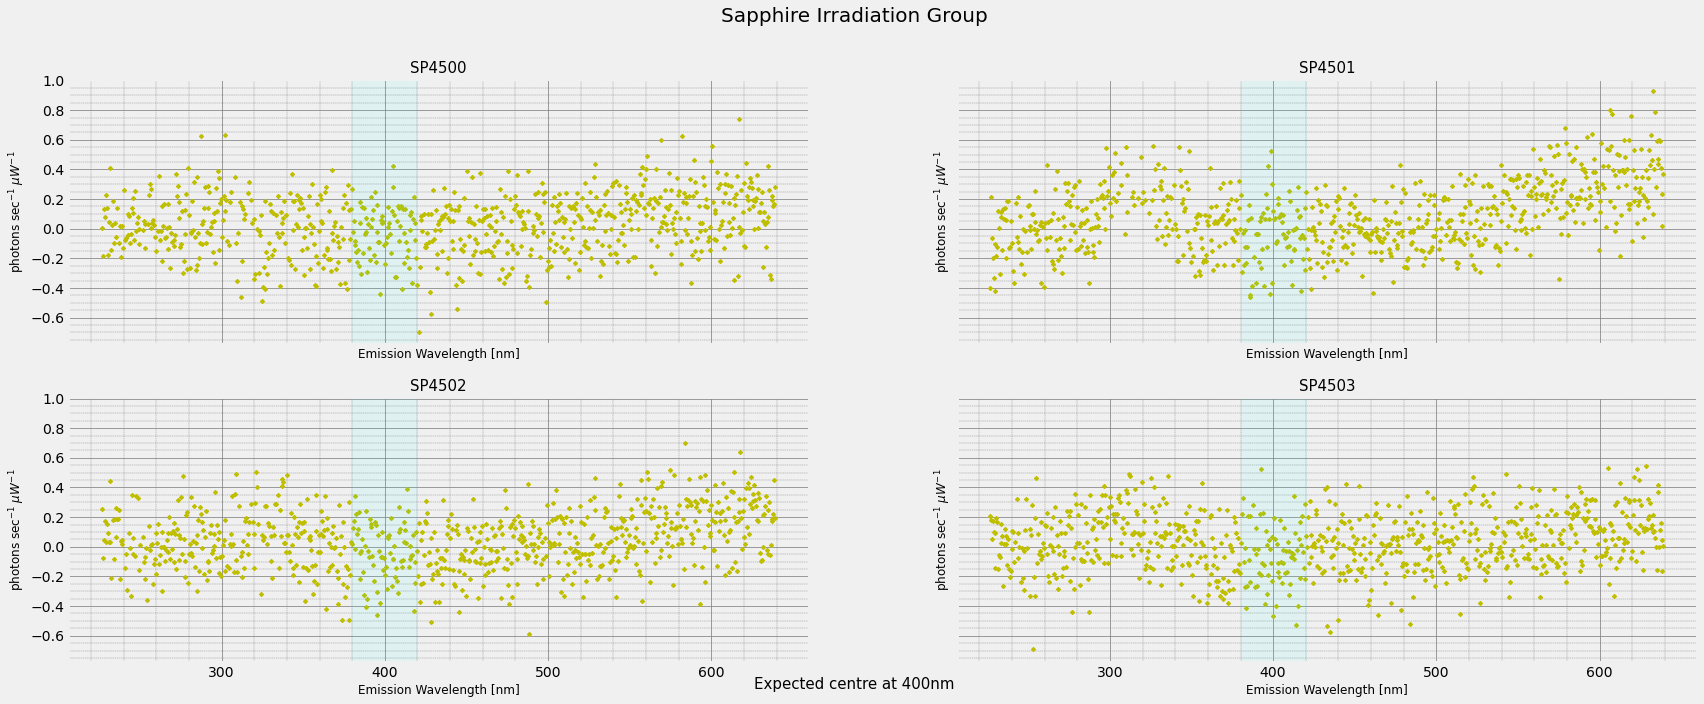

In [14]:
sm = 5
exp_col = 'cyan'
alpha = 0.07

fig, ((ax1,ax2) , (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey=True)

wl = '250'
s1, s2, s3, s4 = get_treated_data('SP4500_A', wl, irrad = True, pr = 12.25, SP=True)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax1.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax1.axvspan(380, 420, alpha=alpha, color=exp_col)

ax1.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax1.minorticks_on()
ax1.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax1.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax1.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax1.set_title('SP4500', fontsize = 15)

wl = '250'
s1, s2, s3, s4 = get_treated_data('SP4501_A', wl, irrad = True, pr = 12.25, SP=True)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax2.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax2.axvspan(380, 420, alpha=alpha, color=exp_col)

ax2.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax2.minorticks_on()
ax2.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax2.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax2.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax2.set_title('SP4501', fontsize = 15)

wl = '250'
s1, s2, s3, s4 = get_treated_data('SP4502_A', wl, irrad = True, pr = 12.25, SP=True)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax3.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax3.axvspan(380, 420, alpha=alpha, color=exp_col)

ax3.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax3.minorticks_on()
ax3.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax3.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax3.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax3.set_title('SP4502', fontsize = 15)

wl = '250'
s1, s2, s3, s4 = get_treated_data('SP4503_A', wl, irrad = True, pr = 12.25, SP=True)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax4.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax4.axvspan(380, 420, alpha=alpha, color=exp_col, label = 'h')

ax4.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax4.minorticks_on()
ax4.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4) 
ax4.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax4.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax4.set_title('SP4503', fontsize = 15)

fig.suptitle('Sapphire Irradiation Group', fontsize=20)

fig.text(0.5, 0.04, 'Expected centre at 400nm', ha='center', va='center', fontsize =15);

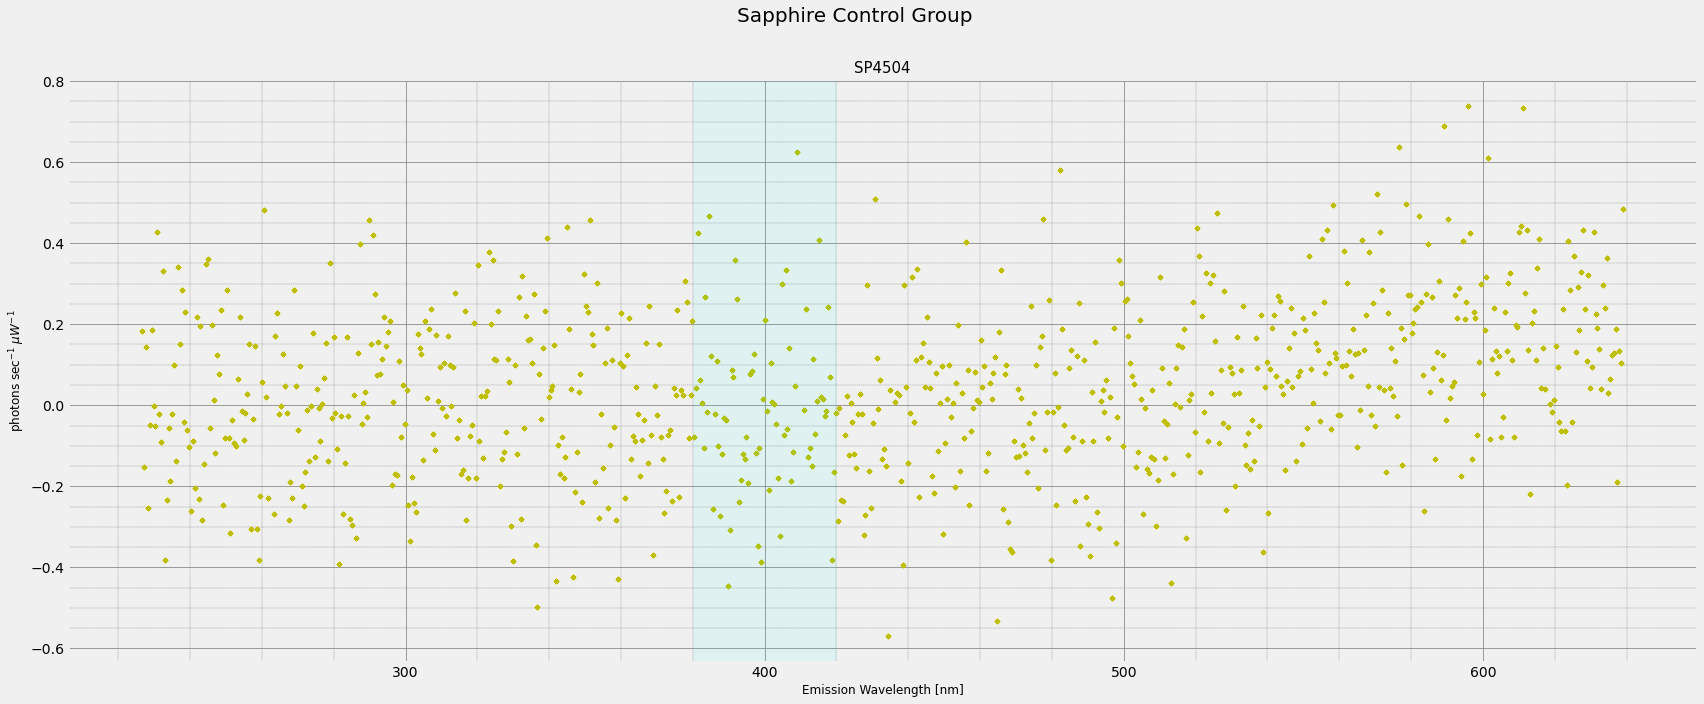

In [15]:
sm = 10
exp_col = 'cyan'
alpha = 0.07

fig, ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey=True)

wl = '250'
s1, s2, s3, s4 = get_treated_data('SP4504_A', wl, irrad = False, pr = 12.25, SP=True)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax1.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax1.axvspan(380, 420, alpha=alpha, color=exp_col)

ax1.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax1.minorticks_on()
ax1.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax1.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax1.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax1.set_title('SP4504', fontsize = 15)

fig.suptitle('Sapphire Control Group', fontsize=20);

# Quartz

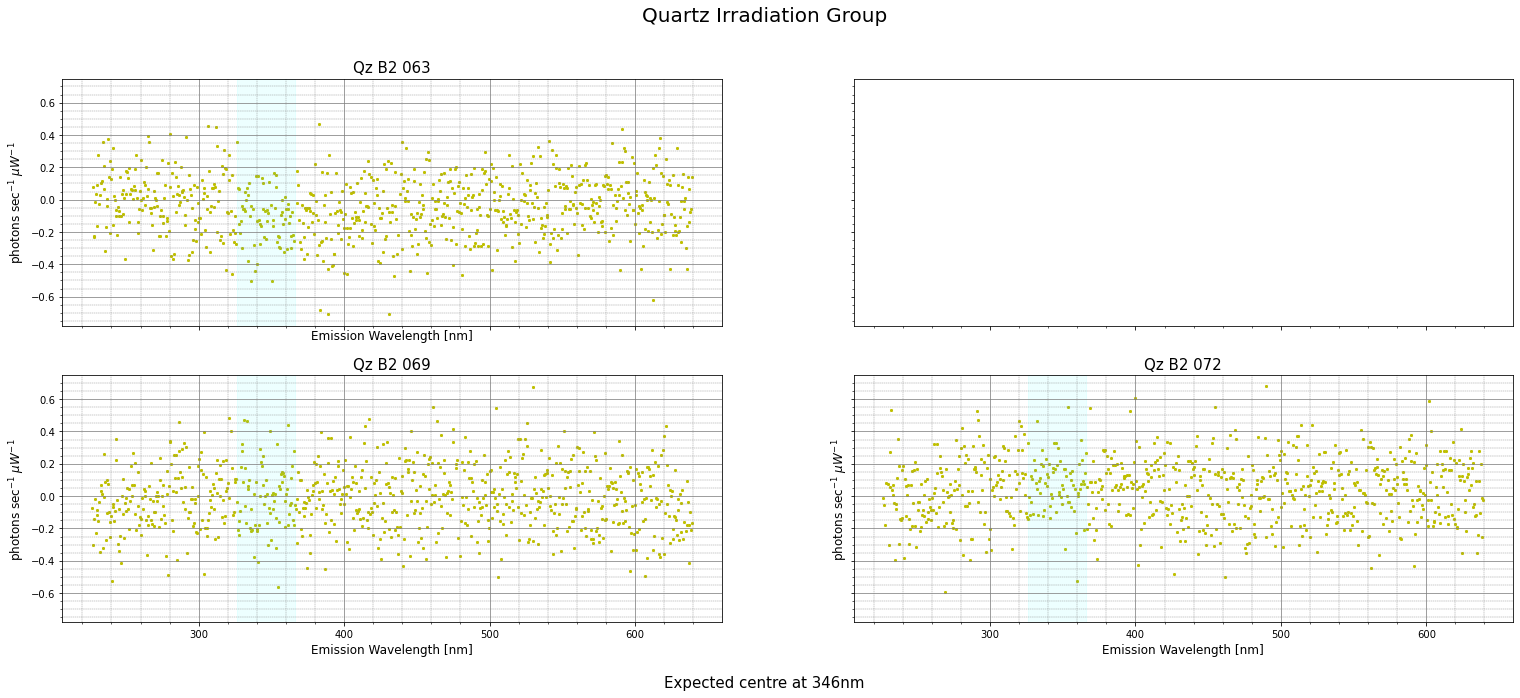

In [8]:
sm = 5
exp_col = 'cyan'
alpha = 0.07
m_exp = 346
tol = 20

fig, ((ax1,ax2) , (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey=True)

wl = '250'
s1, s2, s3, s4 = get_treated_data('Qz_B2_063_A', wl, irrad = True, pr = 12.25)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax1.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax1.axvspan(m_exp-tol, m_exp + tol, alpha=alpha, color=exp_col)

ax1.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax1.minorticks_on()
ax1.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax1.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax1.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax1.set_title('Qz B2 063', fontsize = 15)


wl = '250'
s1, s2, s3, s4 = get_treated_data('Qz_B2_069_A', wl, irrad = True, pr = 12.25)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax3.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax3.axvspan(m_exp-tol, m_exp + tol, alpha=alpha, color=exp_col)

ax3.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax3.minorticks_on()
ax3.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax3.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax3.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax3.set_title('Qz B2 069', fontsize = 15)


wl = '250'
s1, s2, s3, s4 = get_treated_data('Qz_B2_072_A', wl, irrad = True, pr = 12.25)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax4.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax4.axvspan(m_exp-tol, m_exp + tol, alpha=alpha, color=exp_col)

ax4.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax4.minorticks_on()
ax4.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax4.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax4.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax4.set_title('Qz B2 072', fontsize = 15)


fig.suptitle('Quartz Irradiation Group', fontsize=20)

fig.text(0.5, 0.04, 'Expected centre at 346nm', ha='center', va='center', fontsize =15);

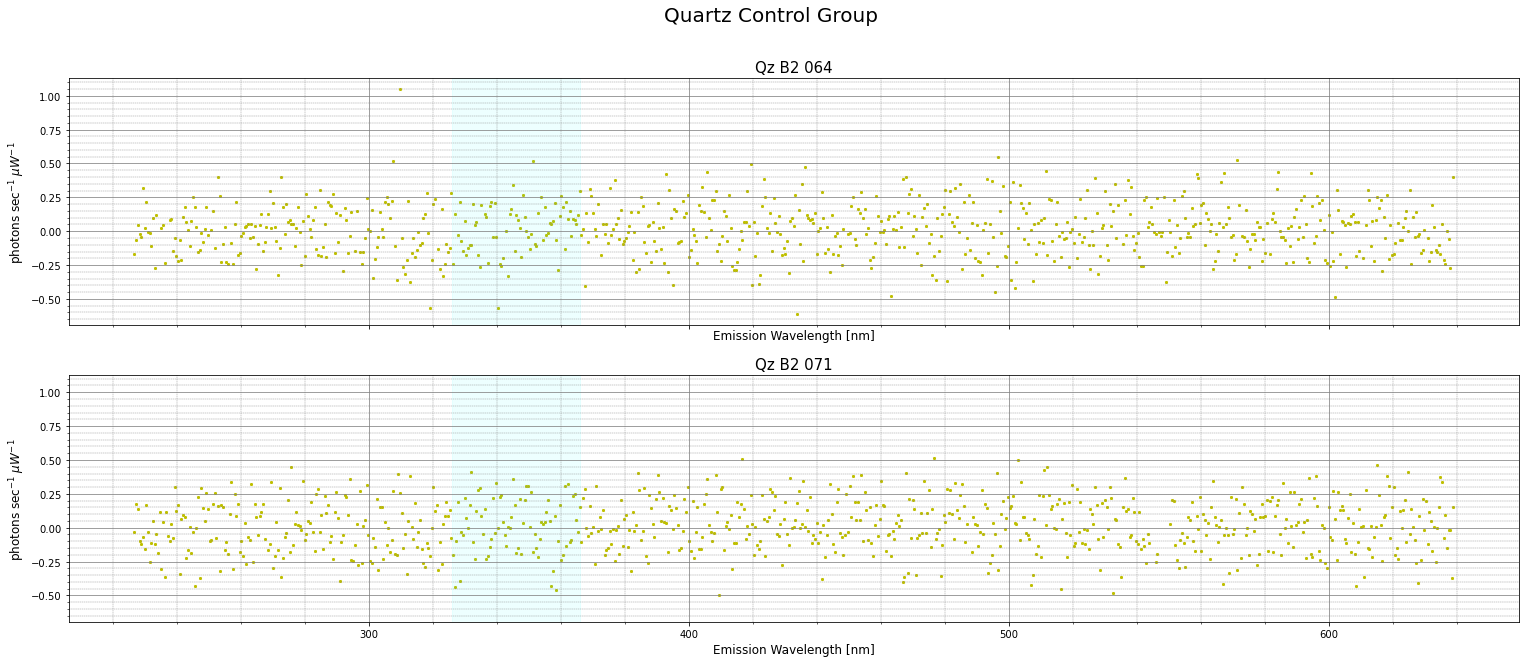

In [9]:
sm = 5
exp_col = 'cyan'
alpha = 0.07
m_exp = 346
tol = 20

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, sharey=True)

wl = '250'
s1, s2, s3, s4 = get_treated_data('Qz_B2_064_A', wl, irrad = False, pr = 12.25)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax1.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax1.axvspan(m_exp-tol, m_exp + tol, alpha=alpha, color=exp_col)

ax1.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax1.minorticks_on()
ax1.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax1.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax1.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax1.set_title('Qz B2 064', fontsize = 15)


wl = '250'
s1, s2, s3, s4 = get_treated_data('Qz_B2_071_A', wl, irrad = False, pr = 12.25)
diff_4_3 = np.subtract(s4[1],s3[1])
diff_4_2 = np.subtract(s4[1],s2[1])
diff_4_1 = np.subtract(s4[1],s1[1])

ax2.scatter(s4[0], diff_4_3, color = 'y', s = sm, marker = 'x')
ax2.axvspan(m_exp-tol, m_exp + tol, alpha=alpha, color=exp_col)

ax2.grid(True, which='both', linestyle='-', linewidth=0.75, color='grey')
ax2.minorticks_on()
ax2.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4)
ax2.set_xlabel('Emission Wavelength [nm]', fontsize = 12)
ax2.set_ylabel(r'photons sec$^{-1} \; \mu W^{-1}$', fontsize = 12)
ax2.set_title('Qz B2 071', fontsize = 15)

fig.suptitle('Quartz Control Group', fontsize=20);

In [7]:
LiF_irrad['coll1']['LiF_B2_157_B'].meta_df

,,,flipperA,spf,lpf,lpf2,mono_gr,spec_gr,gain,bin,spec_temp,pw,date
wavelength,orientation,t_exp,,,,,,,,,,,
435,0,15.0sec,down,FESH0450,FELH0450,EMPTY,1,2,4x,2,NaN,"[6.607e-06, 6.609e-06, 6.651e-06, 6.635e-06]",Sat Sep 23 11:11:12.137 2023


In [11]:
LiF_irrad['coll6']['LiF_B2_145_B'].meta_df

,,,flipperA,spf,lpf,lpf2,mono_gr,spec_gr,gain,bin,spec_temp,pw,date
wavelength,orientation,t_exp,,,,,,,,,,,
435,0,15.0sec,down,FESH0450,FELH0450,EMPTY,1,2,4x,2,NaN,"[5.846e-06, 5.846e-06, 5.846e-06, 5.847e-06]",Thu Nov 16 09:50:10.465 2023


In [8]:
LiF_irrad['coll1']['LiF_B2_157_A'].meta_df

,,,flipperA,spf,lpf,lpf2,mono_gr,spec_gr,gain,bin,spec_temp,pw,date
wavelength,orientation,t_exp,,,,,,,,,,,
260,0,15.0sec,down,EMPTY,EMPTY,LP272,0,1,4x,2,NaN,"[8.015e-07, 8.021e-07, 8.017e-07, 8.022e-07]",Sat Sep 23 11:15:16.522 2023


In [9]:
LiF_irrad['coll1']['LiF_B2_145_A'].meta_df

,,,flipperA,spf,lpf,lpf2,mono_gr,spec_gr,gain,bin,spec_temp,pw,date
wavelength,orientation,t_exp,,,,,,,,,,,
260,0,15.0sec,down,EMPTY,EMPTY,LP272,0,1,4x,2,NaN,"[7.988e-07, 7.985e-07, 7.974e-07, 7.962e-07]",Sat Sep 23 11:04:23.034 2023
